<h2>Data Analytics- notebook, housing example</h2>

<h4><b>Dataset name / short description:</b></h4>

Kansas City Housing Sales data

<h4><b>Data source (url):</b></h4>

https://www.kaggle.com/datasets/astronautelvis/kc-house-data

<h4><b>Data format:</b></h4>

Single csv-file

<h4><b>Data description, features and limitations:</b></h4>

The dataset contains housing data from Kansas City, USA. Time period May 2014 - May 2015. Approximately 21000 buildings in total. Each building has information about square footage, view, waterfront, bedrooms, bathrooms, condition, grade.

The data is limited in the US area of Kansas City and years 2014-2015.

<h3><b>Code: importing modules, custom functions and loading the data</b></h3>

In [ ]:
# typical imports
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# suppress the FutureWarnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# let's create a custom function to create an age group
# from 1 - 4 => 1 => oldest, 4 => newest
def create_age_group(row):
    year = row['yr_built']

    # determine the age group
    # based on year built
    if year >= 2000:
        return 4
    elif 1980 <= year < 2000:
        return 3
    elif 1960 <= year < 1980:
        return 2
    else:
        return 1
    
    
# load a csv-file into a DataFrame
# originally data from: https://www.kaggle.com/datasets/astronautelvis/kc-house-data
df = pd.read_csv("houses.csv")

<h3><b>Code: Data clean-up procedure</b></h3>

Use separate markdown cells if you wish to emphasize an important point or additional information for the reader (see vehicle example)

In [16]:
# let's remove id, zipcode, lat, long
# zipcode would be useful, if we would have better information
# => in which cost category a certain zipcode belongs

# you can also drop/remove multiple columns at once (use a python list)
df = df.drop(["id", "zipcode", "lat", "long"], axis=1)

# sqft_living15, sqft_lot15 => if these are similar to to actual sqft-columns
# we can consider removing

# df['LastUpdateDate'] = pd.to_datetime(df['LastUpdateDate'])
df['Datetime'] = pd.to_datetime(df['date'])

# with DateTime-object, we can nicely get
# year and month as integers  
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month


# remove the original date columns
df = df.drop(["Datetime", "date"], axis=1)

# let's convert the imperial units
# 1 square foot = 0.09290304 square meters
df['living_m2'] = df['sqft_living'] * 0.09290304
df['basement_m2'] = df['sqft_basement'] * 0.09290304
df['lot_m2'] = df['sqft_lot'] * 0.09290304
df['above_m2'] = df['sqft_above'] * 0.09290304

# after transforming the square feet to square meters, remove the original ones
df = df.drop(["sqft_living", "sqft_basement", "sqft_lot", "sqft_above", "sqft_living15", "sqft_lot15"], axis=1)

# 99% of the renovation years are 0 => never renovated or the information is not available
# since most of the data is "missing"
# the most common approach is to drop this column

# however, in this case, we could replace the 0 renovation_year
# with the year of built (=> the last time somebody did any construction in the building)
# let's keep this in mind if we need more point of view, for now, let's remove the renovation year

# after transforming the square feet to square meters, remove the original ones
df = df.drop(["yr_renovated"], axis=1)

# in order to visualize better, we need to remove columns
# even those columns that have a meaning in the dataset
# in machine learning, we usually preserve as many columns as possible
df = df.drop(['Year', 'Month', 'basement_m2', 'lot_m2', 'above_m2'], axis=1)

# remove condition, waterfront and view due to low effect on price
# you can use pairplot to verify this
# doesn't really affect the price that much
# but there are more buildings with a lower condition
df = df.drop(["condition", "waterfront", "view"], axis=1)

# use our custom function to create an age group
df['age_group'] = df.apply(create_age_group, axis=1)

# because we now have the age group 1-4,
# we can remove the original year column
df = df.drop('yr_built', axis=1)

# remove outliers based on normal distribution, anything under -3 or over 3 
# in the distribution, will be removed
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

<h3><b>Code: Data analysis</b></h3>

Use separate markdown cells if you wish to emphasize an important point or additional information for the reader (see vehicle example)

In [ ]:
# we lost about 1500 buildings from the outliers
# notice how the max price now is 1.64 million USD
df.describe()

In [18]:
df.head(5)

,price,bedrooms,bathrooms,floors,grade,living_m2,age_group
0,221900.0,3,1.00,1.0,7,109.625587,1
1,538000.0,3,2.25,2.0,7,238.760813,1
2,180000.0,2,1.00,1.0,6,71.535341,1
3,604000.0,4,3.00,1.0,7,182.089958,2
4,510000.0,3,2.00,1.0,8,156.077107,3


<Axes: >

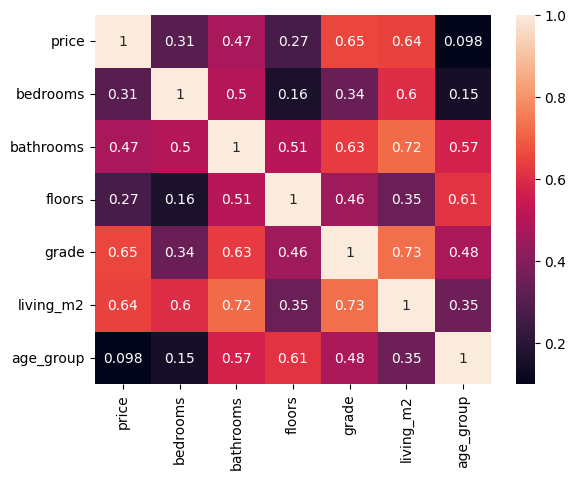

In [19]:
# let's check the correlations now
# price seems to be affected by bedrooms, bathrooms, grade and living m2
# surprisingly, not that much by age group
correlations = df.corr(numeric_only=True)
sns.heatmap(correlations, annot=True)

In [20]:
# because it's difficult to visualize 20000 buildings
# we are going to take a sample
sample = df.sample(2000)

<Axes: xlabel='price', ylabel='Count'>

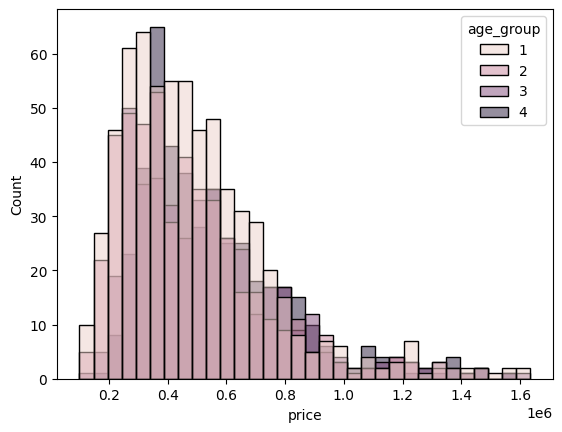

In [21]:
# the age doesn't affect the price that much
sns.histplot(x="price", hue="age_group", data=sample)

<Axes: xlabel='living_m2', ylabel='price'>

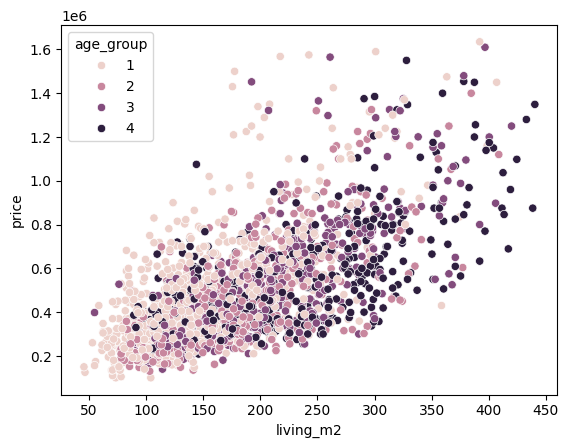

In [22]:
# it seems the living space is larger in newer houses
# age group seems to affect the building size (square meters)
# older buildings tend to be smaller than newer ones, based on this data
sns.scatterplot(x="living_m2", y="price", hue="age_group", data=sample)

In [23]:
# another sample for comparing the grade with price
sample = df.sample(10000)

<Axes: xlabel='living_m2', ylabel='price'>

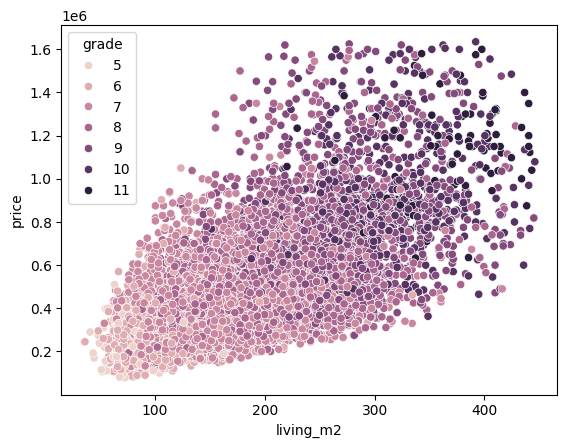

In [24]:
# the price is nicely described by living space and grade
sns.scatterplot(x="living_m2", y="price", hue="grade", data=sample)

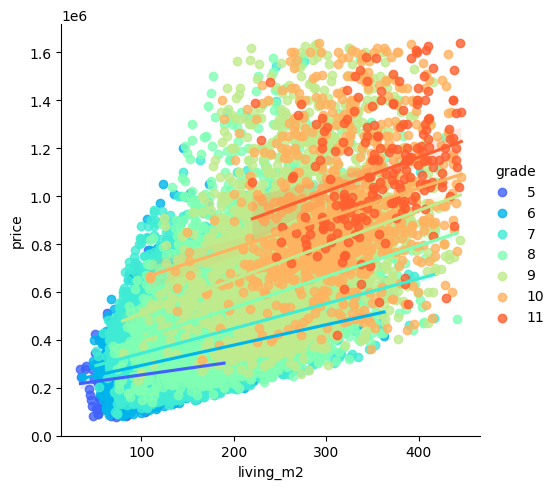

In [25]:
# we can see the correlations here on how the price is formed based on grade and living space
sns.lmplot(x="living_m2", y="price", hue="grade", data=df, palette="rainbow")

<Axes: xlabel='bathrooms', ylabel='price'>

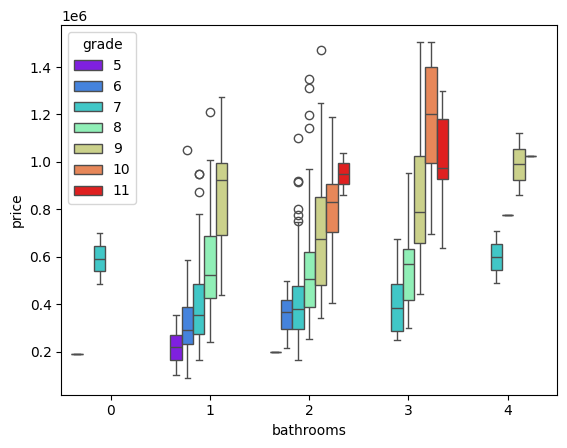

In [26]:
# bathrooms seem to increase the price little by little
sample = df.sample(1000)
sample['bathrooms'] = sample['bathrooms'].astype(int)
sns.boxplot(x="bathrooms", y="price", data=sample, hue="grade", palette="rainbow")

<Axes: xlabel='bedrooms', ylabel='price'>

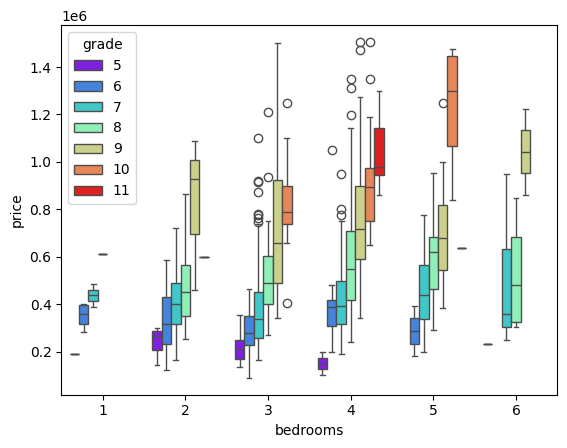

In [27]:
# bedrooms seem to vary more with the price, no clear increase only based on bedrooms
sns.boxplot(x="bedrooms", y="price", data=sample, hue="grade", palette="rainbow")

<h3><b>Results and summary:</b></h3>

The price of a building based on this dataset, seems to be mostly based on number of bathrooms, the grade and living square meters. The age of the building doesn't affect the price directly, but it affects the living square meters (newer hosues are often bigger). Surprisingly, number of bedrooms doesn't seem to directly affect the price in this US housing dataset. 

<h3><b>Ideas for further improvements:</b></h3>

It would be interesting to know if other areas in US on different price levels. Also, to compare this to European house market would be interesting. Combining this dataset other location's data would be interesting. Also, using the zipcode, lat and long values to obtain the actual name of the area in the city; could we find a correlation between certain areas and price levels.

Also, more historical data would probably affect the result.